# AFL Modelling
Predicting the winner of games, with the probability of winning and the margin of win. <br>
Using data from 2015 till 2023 with 2023 to be used as testing data.

In [1]:
#import packages
import polars as pl
import numpy as np
pl.Config.set_fmt_str_lengths(150);
pl.Config.set_tbl_rows(1000);
pl.Config.set_tbl_cols(40);

In [2]:
#set up R extension
%load_ext rpy2.ipython

C:\Users\e_sut\anaconda3\lib\site-packages\rpy2\robjects\packages.py:366: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


Get the fixtures from 2015-2023, taking into account the bye infomation 2019 onwards. 

In [3]:
%%R -o seasons,seasonBye
library('fitzRoy')
library('dplyr')
library('tidyr')

seasonList <- c(2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023)
first <- TRUE
for(s in seasonList) {
    
    df <- fetch_fixture(season = s, comp = "AFLM")

    if (first) {
        seasons <- df
        first <- FALSE
    }else{
        seasons <- seasons %>% 
                      bind_rows(df)
    }
    
}

seasonBye <- seasons %>% 
                select(compSeason.id, compSeason.year, round.roundNumber, round.byes) %>%
                filter(compSeason.year >= 2019) %>%
                unnest(round.byes) %>%
                distinct() %>%
                mutate(round.nextRound = round.roundNumber + 1,
                      ByeFlag = 1) %>%
                select(compSeason.id, round.nextRound, club.id, club.name, ByeFlag)

seasons <- seasons %>% select(-round.byes)
    

R[write to console]: 
Attaching package: 'dplyr'


R[write to console]: The following objects are masked from 'package:stats':

    filter, lag


R[write to console]: The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




v Returning data for "All Rounds, 2015" ... done
v Returning data for "All Rounds, 2016" ... done
v Returning data for "All Rounds, 2017" ... done
v Returning data for "All Rounds, 2018" ... done
v Returning data for "All Rounds, 2019" ... done
v Returning data for "All Rounds, 2020" ... done
v Returning data for "All Rounds, 2021" ... done
v Returning data for "All Rounds, 2022" ... done
v Returning data for "All Rounds, 2023" ... done


Assign -1 as the winner id for a draw, since 2015 there have been 15 draws. We also have a cancelled game, Cats vs. Crows 2015 R14 which we are just going to remove.

In [4]:
#Clean and prep the season bye info
seasonBye = pl.from_pandas(seasonBye).drop('club.id').with_columns(pl.col('round.nextRound').cast(pl.Int32))

In [5]:
#The inital cleaning working with the gneral match details. We can use this as our base for creating the desired attributes
seasonsBase = (pl.from_pandas(seasons)
                .sort('round.id')
                #Keep only the columns we want
                .select('id', 'status', 'compSeason.id', 'compSeason.year', 'round.roundNumber', 'home.team.club.id', 'home.team.name',
                        'away.team.club.id', 'away.team.name', 'home.score.goals', 'home.score.behinds', 'home.score.totalScore',
                        'away.score.goals', 'away.score.behinds', 'away.score.totalScore', 'venue.id', 'venue.name', 'venue.state')
                #Remove the Crows vs. Cats 2015 R14 game which was cancelled
                .filter(pl.col('id') != 847)
                #Label Previous comp year
                .with_columns((pl.col('compSeason.year') - 1).alias('prevComp.year'))
                #Label in sequential order (currently missing numbers in existing round.id) to get the previous games 
     .join((pl.from_pandas(seasons)
                .select('compSeason.year', 'round.roundNumber')
                .unique()
                .sort('compSeason.year', 'round.roundNumber')
                .with_columns(pl.col('round.roundNumber').cum_count().alias('round.id'))), how='left', on=['compSeason.year', 'round.roundNumber'])
     #create the margin
     .with_columns((pl.col('home.score.totalScore') - pl.col('away.score.totalScore')).abs().alias('win.margin'))   
     #Add a bye flag
     .join(seasonBye, how='left', left_on=['compSeason.id', 'round.roundNumber', 'home.team.name'], right_on=['compSeason.id', 'round.nextRound', 'club.name'])
     .join(seasonBye, how='left', left_on=['compSeason.id', 'round.roundNumber', 'away.team.name'], right_on=['compSeason.id', 'round.nextRound', 'club.name'])
     #Rename bye flag
     .rename({'ByeFlag' : 'home.bye.flag',
              'ByeFlag_right' : 'away.bye.flag'})
     #Fill in bye flag nulls
     .with_columns(pl.col('home.bye.flag').fill_null(0).cast(pl.Int32),
                   pl.col('away.bye.flag').fill_null(0).cast(pl.Int32))
    #Fill venue blank states with china (1 is not china but NZ but is in 2015 so we wont worry about that)
    .with_columns(pl.col('venue.state').fill_null('China'))
)

In [6]:
#Add a round id
seasonsBase = (seasonsBase
     .join((seasonsBase
                 .select('compSeason.year', 'round.roundNumber')
                 .unique()
                 .sort('compSeason.year', 'round.roundNumber')
                 .with_columns(pl.col('round.roundNumber').cum_count().alias('round.Id'))), how='left', on=['compSeason.year', 'round.roundNumber'])
)

In [7]:
#Create a dataframe with all the match details (repeated so that boths teams get to be team A and team B)
allMatchesBothSides = (seasonsBase
     .select('compSeason.year', 'round.roundNumber', 'round.Id', 'venue.name', 'home.team.club.id', 'home.team.name', 'home.score.totalScore', 
             'home.score.goals', 'home.score.behinds', 'away.team.club.id', 'away.team.name', 'away.score.totalScore', 'away.score.goals', 'away.score.behinds')
     .rename({'home.team.name': 'team.A.name',
              'home.team.club.id' : 'team.A.club.id',
              'home.score.totalScore' : 'team.A.score.totalScore',
              'home.score.goals' : 'team.A.score.goals',
              'home.score.behinds' : 'team.A.score.behinds',
              'away.team.name': 'team.B.name',
              'away.team.club.id' : 'team.B.club.id',
              'away.score.totalScore' : 'team.B.score.totalScore',
              'away.score.goals' : 'team.B.score.goals',
              'away.score.behinds' : 'team.B.score.behinds'})
     .vstack(seasonsBase
     .select('compSeason.year', 'round.roundNumber', 'round.Id', 'venue.name', 'away.team.club.id', 'away.team.name', 'away.score.totalScore',
             'away.score.goals', 'away.score.behinds', 'home.team.club.id', 'home.team.name', 'home.score.totalScore', 'home.score.goals', 'home.score.behinds')
     .rename({'home.team.name': 'team.B.name',
              'home.team.club.id' : 'team.B.club.id',
              'home.score.totalScore' : 'team.B.score.totalScore',
              'home.score.goals' : 'team.B.score.goals',
              'home.score.behinds' : 'team.B.score.behinds',
              'away.team.name': 'team.A.name',
              'away.team.club.id' : 'team.A.club.id',
              'away.score.totalScore' : 'team.A.score.totalScore',
              'away.score.goals' : 'team.A.score.goals',
              'away.score.behinds' : 'team.A.score.behinds'}))
     .sort('team.A.club.id', 'round.Id')
)

In [8]:
#Create a link between teams club id and the elo index 0-17 
indexTeams = allMatchesBothSides.select('team.A.name', 'team.A.club.id').unique().sort('team.A.club.id').with_columns((pl.col('team.A.name').cum_count() - 1).alias('EloIndex'))

In [9]:
#Add the created team index
seasonsBase = (seasonsBase
                   .join(indexTeams.drop('team.A.club.id'), how='left', left_on='home.team.name', right_on='team.A.name')
                   .rename({'EloIndex' : 'home.team.id'})
                   .join(indexTeams.drop('team.A.club.id'), how='left', left_on='away.team.name', right_on='team.A.name')
                   .rename({'EloIndex' : 'away.team.id'})
                    #Label the id winner (-1 for a draw, 1 for home & 0 for away)
                    .with_columns(pl.when(pl.col('home.score.totalScore') >= pl.col('away.score.totalScore')).then(pl.lit(1))
                                .when(pl.col('home.score.totalScore') < pl.col('away.score.totalScore')).then(pl.lit(0))
                                .alias('winner'))
              )

## Get the ladder poistions at beginning round and last seasons final ladder position.

In [10]:
%%R -o ladder

season <- c(2015,2016,2017,2018,2019,2020,2021, 2022, 2023)
rounds <- c(1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23)
first <- TRUE

for(s in season){
    for(r in rounds){

        if(s==2020 && r <= 18){
            df <- fetch_ladder_afl(season=s, round_number=r)
        }else if(s!=2020){
            df <- fetch_ladder_afl(season=s, round_number=r)
        }

        if(first){
            ladder <- df
            first <- FALSE
        }else{
            ladder <- ladder %>% bind_rows(df)
        }
    }

    if(s== 2023){
        ladder <- ladder %>% bind_rows(fetch_ladder_afl(season=s, round_number=24))
    }
}

ladder = ladder %>% select(season, round_number, position, team.club.id, team.club.name)
        

In [11]:
ladderNormal = (pl.from_pandas(ladder)
     .with_columns((pl.col('round_number') + 1).alias('nextRound'))
     .drop('team.club.id', 'round_number')
                  )

In [12]:
#get the final ladder of each season
ladderFinal = (pl.from_pandas(ladder)
                   #Get the final ladder at the end of the season
                   .filter(pl.col('round_number') == pl.col('round_number').max().over('season'))
                   #get the next season (for assigning to the nest round 1)
                   .with_columns((pl.col('season') + 1).alias('Nextseason'),
                                 pl.lit(1).alias('first_round'))
              )

In [13]:
#Add home and away ladder positions before 
ladderPosition = (seasonsBase
     .select('compSeason.year', 'round.roundNumber')
     .unique()
     .sort('compSeason.year', 'round.roundNumber')
     #from round 2 till finals
     .join(ladderNormal, how='left', left_on=['compSeason.year', 'round.roundNumber'], right_on=['season', 'nextRound'])
     #for round 1 the final ladder of previous season
     .join(ladderFinal.drop('season', 'round_number'), how='left', left_on=['compSeason.year', 'round.roundNumber'], right_on=['Nextseason', 'first_round'])
     .rename({'position_right' : 'position1',
              'team.club.name_right' : 'team.club.name1'})
     #for the finals
     .join(ladderFinal.drop('PrevSeason'), how='left', left_on='compSeason.year', right_on='season')
     #put all the parts together
     .with_columns(pl.when(~pl.col('position').is_null()).then(pl.col('position'))
                     .when(~pl.col('position1').is_null()).then(pl.col('position1')).otherwise(pl.col('position_right')).alias('position'),
                   pl.when(~pl.col('team.club.name').is_null()).then(pl.col('team.club.name'))
                     .when(~pl.col('team.club.name1').is_null()).then(pl.col('team.club.name1')).otherwise(pl.col('team.club.name_right')).alias('team.club.name'))
     #select only what we want
     .select('compSeason.year', 'round.roundNumber', 'team.club.name', 'position')
     .unique()
     .sort('compSeason.year', 'round.roundNumber', 'position')
     #get the fianl positioning of the previous year
     .join(ladderFinal.drop('season', 'round_number', 'first_round', 'team.club.id'), how='left', left_on=['compSeason.year', 'team.club.name'], right_on=['Nextseason', 'team.club.name'])
     .rename({'position_right': 'last.season.position'})
                           
)           

In [14]:
seasonsStep2 = (seasonsBase
                 #join the ladderPosition to get the home teams ladder info
                 .join(ladderPosition.rename({'position':'home.ladder.position', 'last.season.position': 'home.last.season.position'}),
                       how='left',
                       left_on=['compSeason.year', 'round.roundNumber', 'home.team.name'],
                       right_on=['compSeason.year', 'round.roundNumber', 'team.club.name'])
                 #Clean up any duplicates
                 .unique()
                 #join the ladderPosition to get the away teams ladder info
                 .join(ladderPosition.rename({'position':'away.ladder.position', 'last.season.position': 'away.last.season.position'}),
                       how='left',
                       left_on=['compSeason.year', 'round.roundNumber', 'away.team.name'],
                       right_on=['compSeason.year', 'round.roundNumber', 'team.club.name'])
                 #clean up any duplicates
                 .unique()
                 #sort into order
                 .sort('compSeason.year', 'round.roundNumber')
     
                )

## Get the distance travelled

In [15]:
#Create a table for distance between states and where the team is based (based on capital to capital)
vic = pl.Series([0, 654, 714, 2727, 1373, 0, 0, 1373, 0, 0, 0, 654, 0, 0, 0, 2727, 714, 0])
nsw = pl.Series([714, 1165, 0, 3297, 730, 714, 714, 730, 714, 714, 714, 1165, 714, 714, 714, 3297, 0, 714])
qld = pl.Series([1373, 1602, 730, 3613, 0, 1373, 1373, 0, 1373, 1373, 1373, 1602, 1373, 1373, 1373, 3613, 730, 1373])
nt = pl.Series([3140, 2609, 3144, 2647, 2846, 3140, 3140, 2846, 3140, 3140, 3140, 2609, 3140, 3140, 3140, 2647, 3144, 3140])
wa = pl.Series([2727, 2135, 3297, 0, 3613, 2727, 2727, 3613, 2727,2727, 2727, 2135, 2727, 2727, 2727, 0, 3297, 2727])
sa = pl.Series([654, 0, 1165, 2135, 1602, 654, 654, 1602, 654, 654, 654, 0, 654, 654, 654, 2135, 1165, 654])
tas = pl.Series([597, 1161, 1056, 3015, 1786, 597, 597, 1786, 597, 597, 597, 1161, 597, 597, 597, 3015, 1161, 597])
act = pl.Series([467, 960, 942, 3095, 942, 467, 467, 247, 467, 467, 467, 960, 467, 467, 467, 3095, 247, 467])
china = pl.Series([8036, 6956, 7592, 7050, 6225, 8036, 8036, 6225, 8036, 8036, 8036, 6956, 8036, 8036, 8036, 7050, 7592, 8036])
distanceTravelled = (seasonsBase
                         .select('home.team.name', 'home.team.club.id').unique()
                         .sort('home.team.name')
                         .with_columns(vic.alias('VIC'),
                                       nsw.alias('NSW'),
                                       qld.alias('QLD'),
                                       nt.alias('NT'),
                                       wa.alias('WA'),
                                       sa.alias('SA'),
                                       tas.alias('TAS'),
                                       act.alias('ACT'),
                                       china.alias('China'))
                         .rename({'home.team.name' : 'team.name'})
                         .drop('home.team.club.id')
                         .melt(id_vars='team.name', variable_name='State', value_name='Distance')
                        )

In [16]:
seasonStep3 = (seasonsStep2
                 #Home team distance travelled to venue
                 .join(distanceTravelled.rename({'Distance' : 'home.distance'}), how='left', left_on=['home.team.name', 'venue.state'], right_on=['team.name', 'State'])
                 #Away team distance travelled to venue
                 .join(distanceTravelled.rename({'Distance' : 'away.distance'}), how='left', left_on=['away.team.name', 'venue.state'], right_on=['team.name', 'State'])
                )

## Team ELO Rating

In [17]:
#create a function to find a teams prediction
def eloTeamPrediction(ratingTeamA, ratingTeamB):
    exp = (-1*(ratingTeamA - ratingTeamB))/400
    b = 1 + 10 ** exp
    result = 1/b
    return result

In [18]:
#create a function to find the teams result, inital B = 0.004 per Multifactorial analysis of factors influencing elite australian football match outcomes: a machine learning approach
def eloTeamResult(scoreTeamA, scoreTeamB):
    exp = -0.04*(scoreTeamA - scoreTeamB)
    b = 1 + np.exp(exp)
    result = 1/b
    return result

In [19]:
#Create a function to get change in teams elo, set K=67.559 per Multifactorial analysis of factors influencing elite australian football match outcomes: a machine learning approach
def eloChange(ratingTeamA, ratingTeamB, scoreTeamA, scoreTeamB):
    #get Team prediction
    prediction = eloTeamPrediction(ratingTeamA, ratingTeamB)
    
    #get actual result
    actual = eloTeamResult(scoreTeamA , scoreTeamB)
    
    #get elo change
    result = 20*(actual - prediction)
    
    #get new elo
    newElo = ratingTeamA + result
    
    return newElo

In [20]:
#Create a function to get the elo for the start of the season, set Carry over at 0.70628 per Multifactorial analysis of factors influencing elite australian football match outcomes: a machine learning approach
def eloNewSeason(lastElo):
    carryOver = 0.80
    result = carryOver * lastElo + 1500 * (1 - carryOver)
    return result

In [21]:
#Function to rule them all! assign elo values
def eloFucntions(roundNumber, teamAScore, teamBScore, prevEloA, prevEloB):
    #If first round of the season get the carry over elo value
    if roundNumber == 1:
        elo = eloNewSeason(prevEloA)
    #If normal round then find new score
    else:
        elo = eloChange(prevEloA, prevEloB, teamAScore, teamBScore)
    #return current elo 
    return elo   
   
    

In [22]:
#Elo list of lists to record elo's and access past elo values, with index = elo index translation found in eloIndexTeams table
#Starting elo as default 1500
eloScores = [[1500] * 18]
#starting roundIndex 

In [23]:
def eloNumber(roundId, roundNumber, clubA, clubB, roundIdA, roundIdB, indexA, indexB):
    #set roundId for indexing
    roundId = roundId - 1
    #create default elo
    elo=1500.0
    #Check if new round by checking a new list has been added for the round
    if roundId >= np.shape(eloScores)[0]:
        #Append new list for new round
        eloScores.append(eloScores[roundId - 1])
        
    #Deal with very first round we consider, simply create base for next round
    if roundId == 0:
        elo = 1500.0
    #For all other rounds get the elo
    else: 
        
        #Get the new elo score
        elo = eloFucntions(roundNumber, teamScores[clubA][roundIdA-1], teamScores[clubB][roundIdB-1], eloScores[roundId-1][indexA], eloScores[roundId-1][indexB])
        #Change list of list to reflect the new score
        eloScores[roundId][indexA] = elo
        

    #Return Elo
    return elo
        

In [24]:
teamScores = dict(allMatchesBothSides.drop('team.B.club.id', 'team.B.name', 'team.B.score.totalScore').group_by('team.A.name').agg(pl.col('team.A.score.totalScore')).to_numpy())

In [25]:
eloScoreDF = (allMatchesBothSides
                 #Get the cleaned indexes for A teams
                 .join(indexTeams.rename({'EloIndex': 'elo.index.A'}).drop('team.A.club.id'), how='left', on='team.A.name')
                 #Get the cleaned indexes for B teams
                 .join(indexTeams.rename({'EloIndex': 'elo.index.B'}).drop('team.A.club.id'), how='left', left_on='team.B.name', right_on='team.A.name')
                 .with_columns((pl.col('team.A.name').cum_count() - 1).over(pl.col('team.A.name')).alias('team.A.round.index'))
                 .sort('round.Id', 'team.B.name')
                 .with_columns((pl.col('team.B.name').cum_count() - 1).over(pl.col('team.B.name')).alias('team.B.round.index'))
                 #sort so the assigning of elo scores are pasted on past club info
                 .sort('round.Id', 'team.A.name')
                 #Get the elo scores
                 .with_columns(pl.struct(['round.roundNumber', 'round.Id', 'team.A.name', 'team.B.name', 'team.A.round.index', 'team.B.round.index', 'elo.index.A', 'elo.index.B'])
                                 .map_elements(lambda x : eloNumber(x['round.Id'], x['round.roundNumber'], x['team.A.name'], x['team.B.name'], x['team.A.round.index'], x['team.B.round.index'], x['elo.index.A'], x['elo.index.B']))
                                 .alias('elo.score'))
                 #Keep only the info we actually want
                 .select('compSeason.year', 'round.roundNumber', 'round.Id', 'team.A.name', 'elo.score')
                )

%%R -o roundZero
roundZero <- fetch_fixture()  %>% 
                select(-round.byes) 


print(roundZero)

LastRoundEloScores = eloScoreDF.with_columns(pl.col('round.Id').max().over('team.A.name').alias('lastRound')).filter(pl.col('round.Id') == pl.col('lastRound'))

#Use the elo score to predict opening round
(pl.from_pandas(roundZero)
     .filter(pl.col('round.roundNumber') == 0)
     .select('home.team.id', 'home.team.name', 'away.team.id', 'away.team.name')
     .join(LastRoundEloScores, how='left', left_on='home.team.name', right_on='team.A.name')
     .rename({'elo.score':'home.elo.score'})
     .join(LastRoundEloScores, how='left', left_on='away.team.name', right_on='team.A.name')
     .rename({'elo.score':'away.elo.score'})
     #get elo for new season
     .with_columns(pl.col('home.elo.score').map_elements(lambda x: eloNewSeason(x)).alias('home.predict.elo'),
                   pl.col('away.elo.score').map_elements(lambda x: eloNewSeason(x)).alias('away.predict.elo'))
     #get prediction
     .with_columns(pl.when(pl.col('home.predict.elo') > pl.col('away.predict.elo')).then(pl.col('home.team.name')).otherwise(pl.col('away.team.name')).alias('Prediction'))
     #sort columes
     .select('home.team.name', 'away.team.name', 'home.predict.elo', 'away.predict.elo', 'Prediction')
 
)

In [26]:
#Join the elo scores up into the main dataframe
seasonStep3 = (seasonsStep2
     #elo scores for the home teams
     .join(eloScoreDF.rename({'elo.score' : 'home.elo.score'}),
           how='left',
           left_on=['compSeason.year', 'round.roundNumber', 'round.Id', 'home.team.name'],
           right_on=['compSeason.year', 'round.roundNumber', 'round.Id', 'team.A.name'])
     #elo scores for the away teams
    .join(eloScoreDF.rename({'elo.score' : 'away.elo.score'}),
           how='left',
           left_on=['compSeason.year', 'round.roundNumber', 'round.Id', 'away.team.name'],
           right_on=['compSeason.year', 'round.roundNumber', 'round.Id', 'team.A.name'])
)

#Test the predictive power of the ELO scores (sitting at about 62% accuracy in 2023 so at least more than simply choosing the home team!)
(seasonStep3.with_columns(pl.when(pl.col('home.elo.score') > pl.col('away.elo.score')).then(pl.col('home.team.name'))
                           .when(pl.col('away.elo.score') > pl.col('home.elo.score')).then(pl.col('away.team.name')).otherwise(pl.lit(-1)).alias('Prediction'))
             .with_columns(pl.when(pl.col('Prediction') == pl.col('winner')).then(pl.lit(1)).otherwise(pl.lit(0)).alias('Correct'))
             .filter(pl.col('compSeason.year') == 2023)
             .group_by('Correct')
             .len()
)

## Home Advantage/Disadvantage
Turns out (even not considering 2020, which we are) the term 'home team' can mean fairly little which might go some way to explaining how the chances of winning if the home team is only slightly elvated due to been the home team. Therefore to consider this, we will get the portion of games each time played at the venue in the previous year, this of course can mean that there are some venues that no-one played at last year and the advantage/disadvantage will be 0 (and not undefinied).

In [39]:
#Get the portion of games played at venue current season
teamRoundVenue = (allMatchesBothSides
                      .drop('venue.name')
                      #Get the venues attached for both team A and team B
                     .join(seasonsBase.select('round.Id', 'home.team.name', 'venue.name'), how='left', left_on=['round.Id', 'team.A.name'], right_on=['round.Id', 'home.team.name'])
                     .join(seasonsBase.select('round.Id', 'away.team.name', 'venue.name'), how='left', left_on=['round.Id', 'team.A.name'], right_on=['round.Id', 'away.team.name'])
                     #Get all the venues in the same column
                     .with_columns(pl.when(pl.col('venue.name').is_null()).then(pl.col('venue.name_right')).otherwise(pl.col('venue.name')).alias('venue.name'))
                      #Drop columns not required going forward
                     .drop('venue.name_right', 'team.A.score.totalScore', 'team.B.club.id', 'team.B.name', 'team.B.score.totalScore')
                     #Get the total number of games played each season by each team
                     .with_columns(pl.col('round.Id').len().over('compSeason.year', 'team.A.name').alias('GamesPlayed'))
                     #Get the number of times each team played at a venue during a season
                     .group_by('compSeason.year', 'team.A.name', 'venue.name')
                     .agg(pl.col('GamesPlayed').first(),
                          pl.col('round.Id').len().alias('VenuePlayed'))
                     #How much of their time did the team spend at any venue
                     .with_columns((pl.col('VenuePlayed')/pl.col('GamesPlayed')).alias('VenuePortion'))
                     .sort('compSeason.year', 'team.A.name', 'VenuePlayed')
                     #Create the next season so we can join to get portion of time played last season
                     .with_columns((pl.col('compSeason.year') + 1).alias('NextSeason'))
                      #Keep only what we need going forward
                     .select('NextSeason', 'team.A.name', 'venue.name', 'VenuePortion')
                 )

In [41]:
#Get portion of games played at venue last season
teamRoundVenue = (allMatchesBothSides
                      .drop('venue.name')
                      #Again get all the venues in the same column and keep only what required
                     .join(seasonsBase.select('round.Id', 'home.team.name', 'venue.name'), how='left', left_on=['round.Id', 'team.A.name'], right_on=['round.Id', 'home.team.name'])
                     .join(seasonsBase.select('round.Id', 'away.team.name', 'venue.name'), how='left', left_on=['round.Id', 'team.A.name'], right_on=['round.Id', 'away.team.name'])
                     .with_columns(pl.when(pl.col('venue.name').is_null()).then(pl.col('venue.name_right')).otherwise(pl.col('venue.name')).alias('venue.name'))
                     .drop('venue.name_right', 'team.A.score.totalScore', 'team.B.club.id', 'team.B.name', 'team.B.score.totalScore')
                     #Get the previous seasons portion of games played at any venue
                     .join(teamRoundVenue, how='left', left_on=['compSeason.year', 'team.A.name', 'venue.name'], right_on=['NextSeason', 'team.A.name', 'venue.name'])
                     #For venue not played at the previous 
                     .with_columns(pl.col('VenuePortion').fill_null(0))
                     .select('round.Id', 'team.A.name', 'venue.name', 'VenuePortion')
                )

In [42]:
#Attach back to the seasonsStep3 and calculate the home advatage and disadvantage
seasonStep4 = (seasonStep3
     #join portion for home teams
     .join(teamRoundVenue, how='left', left_on=['round.Id', 'home.team.name', 'venue.name'], right_on=['round.Id', 'team.A.name', 'venue.name'])
     #join portion for away.teams
     .join(teamRoundVenue, how='left', left_on=['round.Id', 'away.team.name', 'venue.name'], right_on=['round.Id', 'team.A.name', 'venue.name'])
     #claify the column names
     .rename({'VenuePortion' : 'home.venue.portion',
              'VenuePortion_right' : 'away.venue.portion'})
     #create home advantage
     .with_columns(pl.when(pl.col('away.venue.portion') == 0).then(pl.lit(1)).otherwise((pl.col('home.venue.portion') / pl.col('away.venue.portion'))).alias('home.advantage'))
     #Create away disadvantage
     .with_columns(pl.when(pl.col('home.venue.portion') == 0).then(pl.lit(1)).otherwise((pl.col('away.venue.portion')/pl.col('home.venue.portion'))).alias('away.advantage'))
)

## Days Between Matches
Have to go in and get afttables match info to get dates (would this work with upcoming matches, may need to be revised if not)

In [43]:
%%R -o seasons
seasonList <- c(2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023)
#seasonList <- c(2015)
first <- TRUE
for(s in seasonList) {
    
    df <- fetch_fixture(season = s, comp = "AFLM", source='footywire')

    if (first) {
        seasons <- df
        first <- FALSE
    }else{
        seasons <- seasons %>% 
                      bind_rows(df)
    }
}
seasons <- seasons  %>%
    select(Date, Season, Round, Home.Team, Away.Team)

In [44]:
#Get the dates into python and convert the datetime into just a date
matchDate = (pl.from_pandas(seasons)
                 .with_columns(pl.col('Date').dt.date())
                 .melt(id_vars=['Date', 'Season', 'Round'], value_vars=['Home.Team', 'Away.Team'], value_name='Team', variable_name='Remove')
                 .drop('Remove')
                 .sort('Team', 'Date')
                 .with_columns(pl.col('Team').cum_count().over('Team').alias('team.round.id'))
            )

In [45]:
#Create the date of the past date for each team
matchDate2 = (matchDate
                 #Get the last match id, setting the very first to indicate that there was no match previous
                 .with_columns(pl.when(pl.col('team.round.id') == 1).then(pl.lit(0)).otherwise(pl.col('team.round.id') - 1).alias('team.round.id.past'))
                 #join with itself to get the last match date
                 .join(matchDate.drop('Season'), how='left', left_on=['Team', 'team.round.id.past'], right_on=['Team', 'team.round.id'])
                 .rename({'Date_right' : 'date.last'})
                 #find days difference between the two games
                 .with_columns((pl.col('Date') - pl.col('date.last')).dt.total_days().alias('day.since.match'))
                 #keep only what I want
                 .select('Season', 'Round', 'Team', 'day.since.match')
                 #cast round to int\
                 .with_columns(pl.col('Round').cast(pl.Int32))
                 #convert any team names that require as much
                 .with_columns(pl.col('Team').replace(old=['Adelaide', 'GWS', 'Geelong', 'Gold Coast', 'West Coast', 'Footscray', 'Sydney'],
                                              new=['Adelaide Crows', 'GWS Giants', 'Geelong Cats', 'Gold Coast Suns', 'West Coast Eagles', 'Western Bulldogs', 'Sydney Swans']))
           
            )

In [46]:
#Add the days back to main table
seasonStep5 = (seasonStep4
                 #join the home team days since last played
                 .join(matchDate2, how='left', left_on=['compSeason.year', 'round.roundNumber', 'home.team.name'], right_on=['Season', 'Round', 'Team'])
                 .rename({'day.since.match' : 'home.day.last.match'})
                 #join the awway team days since last played
                 .join(matchDate2, how='left', left_on=['compSeason.year', 'round.roundNumber', 'away.team.name'], right_on=['Season', 'Round', 'Team'])
                 .rename({'day.since.match' : 'away.day.last.match'})
                )

## Attacking, defending and opposition Strength
AFL has both goals and behinds so, we will count goals and add give points a value of 0.5 to reflect that they are of lesser value to the game than a goal.

In [47]:
#Get the goals scored and given away and the margin of each game. Add in the ladder positions as well
allMatchesBothSidesStats = (allMatchesBothSides
                 #Goals scored
                 .with_columns((pl.col('team.A.score.goals') + (pl.col('team.A.score.behinds')*0.5)).alias('strength.attack'))
                 #Goals given away
                 .with_columns((pl.col('team.B.score.goals') + (pl.col('team.B.score.behinds')*0.5)).alias('strength.defense'))
                 #goal diff , i.e. margin
                 #.with_columns((pl.col('team.A.score.totalScore') - pl.col('team.B.score.totalScore')).abs().alias('margin'))
                 #keep only what I want
                 .select('compSeason.year', 'round.roundNumber', 'round.Id', 'team.A.club.id', 'team.A.name', 'team.B.club.id', 'team.B.name',
                         'strength.attack', 'strength.defense', 'team.A.score.totalScore', 'team.B.score.totalScore')
                 #Cast round.id to int rather an unsigned int
                 .with_columns(pl.col('round.Id').cast(pl.Int32))
            )     

In [48]:
#Get the each teams rolling 5 game strength based on margin
matchTeamStats = (allMatchesBothSidesStats
                    #get the previous 5 games margin average of opposition
                    #Start with descending round.id for rolling groupby statements
                    .sort(['team.A.name', 'round.Id'], descending=[False, True])
                    #Try a rolling previous avg margin
                    .sort('team.A.name', 'round.Id')
                    .rolling(index_column='round.Id', period='5i', closed='left', by='team.A.name')
                    .agg(pl.col('team.A.score.totalScore').sum().alias('rolling.team.A.totalScore'),
                         pl.col('team.B.score.totalScore').sum().alias('rolling.team.B.totalScore'))
                    #get the avg margin
                    .with_columns(((pl.col('rolling.team.A.totalScore') - pl.col('rolling.team.B.totalScore'))/5).alias('rolling.margin.avg'))
                    #join back up to df
                    .join(allMatchesBothSidesStats, how='left', on=['team.A.name', 'round.Id'])
                    #arrange columns as desired
                    .select('compSeason.year', 'round.roundNumber', 'team.A.name', 'strength.attack',
                            'strength.defense', 'rolling.margin.avg')
                    #Get the previous 5 matches attacking strength
                    .with_columns(pl.col('strength.attack').shift().over('team.A.name').alias('strength.attack.t-1'),
                                  pl.col('strength.attack').shift(2).over('team.A.name').alias('strength.attack.t-2'),
                                  pl.col('strength.attack').shift(3).over('team.A.name').alias('strength.attack.t-3'),
                                  pl.col('strength.attack').shift(4).over('team.A.name').alias('strength.attack.t-4'),
                                  pl.col('strength.attack').shift(5).over('team.A.name').alias('strength.attack.t-5'))
                    #Get the previous 5 matches defending strength
                    .with_columns(pl.col('strength.defense').shift().over('team.A.name').alias('strength.defense.t-1'),
                                  pl.col('strength.defense').shift(2).over('team.A.name').alias('strength.defense.t-2'),
                                  pl.col('strength.defense').shift(3).over('team.A.name').alias('strength.defense.t-3'),
                                  pl.col('strength.defense').shift(4).over('team.A.name').alias('strength.defense.t-4'),
                                  pl.col('strength.defense').shift(5).over('team.A.name').alias('strength.defense.t-5'))
                    #drop the original strength metrics
                    .drop('strength.attack', 'strength.defense')

                    
                )

In [49]:
#Attach the stats for the home team, i.e. own strength.attack, strength.defense and as away's opposition strength
seasonStep6 = (seasonStep5
     #let's do a bit of cleaning first remove some of the unneeded columns
     .drop('id', 'status', 'compSeason.id', 'home.advantage', 'away.advantage')
     #join for home team
     .join(matchTeamStats, how='left',
           left_on=['compSeason.year', 'round.roundNumber', 'home.team.name'],
           right_on=['compSeason.year', 'round.roundNumber', 'team.A.name'])
 
     #get past strengths of home team
     .rename({'strength.attack.t-1' : 'home.attack.t-1',
              'strength.attack.t-2' : 'home.attack.t-2',
              'strength.attack.t-3' : 'home.attack.t-3',
              'strength.attack.t-4' : 'home.attack.t-4',
              'strength.attack.t-5' : 'home.attack.t-5',
              'strength.defense.t-1' : 'home.defense.t-1',
              'strength.defense.t-2' : 'home.defense.t-2',
              'strength.defense.t-3' : 'home.defense.t-3',
              'strength.defense.t-4' : 'home.defense.t-4',
              'strength.defense.t-5' : 'home.defense.t-5',
              #For the away team the oppositions strength
              'rolling.margin.avg' : 'away.opposition.strength'})
 
      #join for away team
     .join(matchTeamStats, how='left',
           left_on=['compSeason.year', 'round.roundNumber', 'away.team.name'],
           right_on=['compSeason.year', 'round.roundNumber', 'team.A.name'])
 
     #get past strengths of away team
     .rename({'strength.attack.t-1' : 'away.attack.t-1',
              'strength.attack.t-2' : 'away.attack.t-2',
              'strength.attack.t-3' : 'away.attack.t-3',
              'strength.attack.t-4' : 'away.attack.t-4',
              'strength.attack.t-5' : 'away.attack.t-5',
              'strength.defense.t-1' : 'away.defense.t-1',
              'strength.defense.t-2' : 'away.defense.t-2',
              'strength.defense.t-3' : 'away.defense.t-3',
              'strength.defense.t-4' : 'away.defense.t-4',
              'strength.defense.t-5' : 'away.defense.t-5',
              #For the home team the oppositions strength
              'rolling.margin.avg' : 'home.opposition.strength'})
            
    )
 

## Player Rankings


In [50]:
%%R -o seasons
season <- c(2015,2016,2017,2018,2019,2020,2021, 2022, 2023)
first <- TRUE
for(s in seasonList) {
    
    df <- fetch_player_stats(season=s) %>% mutate('compSeason.year' = s) %>% select(compSeason.shortName, compSeason.year, round.roundNumber, teamId, team.name, player.playerId, player.givenName, player.surname, ratingPoints)

    if (first) {
        seasons <- df
        first <- FALSE
    }else{
        seasons <- seasons %>% 
                      bind_rows(df)
    }
}
    


v Fetching match ids ... done
v Finding player stats for 207 matches. ... done
v Fetching match ids ... done
v Finding player stats for 207 matches. ... done
v Fetching match ids ... done
v Finding player stats for 207 matches. ... done
v Fetching match ids ... done
v Finding player stats for 207 matches. ... done
v Fetching match ids ... done
v Finding player stats for 207 matches. ... done
v Fetching match ids ... done
v Finding player stats for 162 matches. ... done
v Fetching match ids ... done
v Finding player stats for 207 matches. ... done
v Fetching match ids ... done
v Finding player stats for 207 matches. ... done
v Fetching match ids ... done
v Finding player stats for 216 matches. ... done


In [51]:
playerPoints = (pl.from_pandas(seasons)
                     .drop('roundId')
                     .join(seasonsBase.select('compSeason.year', 'round.roundNumber', 'round.Id'), how='left', on=['compSeason.year', 'round.roundNumber'])
                     .unique()
                     .with_columns(pl.col('round.Id').cast(pl.Int32))
               )

In [52]:
#Create the base of the player ratings
playerRatings = (playerPoints
     .sort('player.playerId', 'compSeason.year', 'round.roundNumber')
     .sort('player.playerId', 'round.Id')
     #get sum of past 10 games
     .rolling(index_column='round.Id', period='10i', by=['player.playerId', 'player.givenName', 'player.surname'])
     .agg(pl.col('ratingPoints').sum().alias('rolling.player.points'))
     .sort('player.playerId', 'round.Id')
     #get the next round to join on
     .with_columns(pl.col('round.Id').shift(-1).over('player.playerId').alias('round.nextRound'))
     #join back up to get the team
     .join(playerPoints.select('round.Id', 'teamId', 'team.name', 'player.playerId'), on=['round.Id', 'player.playerId'])
     .sort('player.playerId', 'round.Id')
)

In [53]:
#get the sum of teams rating
sumedteamRating = (playerPoints
    .group_by('team.name', 'round.Id')
    .agg(pl.col('ratingPoints').sum())
    .sort('team.name', 'round.Id')
    .rolling(index_column='round.Id', period='10i', by=['team.name'])
    .agg(pl.col('ratingPoints').sum().alias('rolling.ratingPoints'))
    .with_columns(pl.col('round.Id').shift(-1).over('team.name').alias('nextRound'))
)

In [54]:
#Look at getting top players later
#%%R -o lineUp
#
#season <- c(2015,2016,2017,2018,2019,2020,2021, 2022, 2023)
#rounds <- c(1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23)
#first <- TRUE
#
#for(s in season){
#    print(s)
#    for(r in rounds){
#        print(r)
#        if(s==2020 && r <= 18){
#            df <- fetch_lineup(season=s, round_number=r) %>% mutate('compSeason.year' = s)
#        }else if(s!=2020){
#            df <- fetch_lineup(season=s, round_number=r) %>% mutate('compSeason.year' = s)
#        }#
#
#        if(first){
#            lineUp <- df
#            first <- FALSE
#        }else{
#            lineUp <- lineUp %>% bind_rows(df)
#        }
#    }#
#
#}#
#
#lineUp = lineUp %>% select(compSeason.year, round.roundNumber, teamName, player.playerId)

In [55]:
seasonStep7 = (seasonStep6
     .with_columns(pl.col('round.Id').cast(pl.Int32))
     #join home teams ratings
     .join(sumedteamRating.drop('round.Id'), how='left', left_on=['home.team.name', 'round.Id'], right_on=['team.name', 'nextRound'])
     .rename({'rolling.ratingPoints' : 'home.team.playerPoints'})
     #join away tea,s ratings
     .join(sumedteamRating.drop('round.Id'), how='left', left_on=['away.team.name', 'round.Id'], right_on=['team.name', 'nextRound'])
     .rename({'rolling.ratingPoints' : 'away.team.playerPoints'})
)

## Keep and Order the final dataframe

In [56]:
dataFinal = (seasonStep7
             .select('round.Id', 'compSeason.year', 'home.team.id', 'home.bye.flag', 'home.ladder.position', 'home.elo.score', 'home.venue.portion', 'home.day.last.match', 'home.attack.t-1', 'home.attack.t-2',
                   'home.attack.t-3', 'home.attack.t-4', 'home.attack.t-5', 'home.defense.t-1', 'home.defense.t-2', 'home.defense.t-3', 'home.defense.t-4', 'home.defense.t-5', 'home.opposition.strength',
                   'home.team.playerPoints', 'away.team.id', 'away.bye.flag', 'away.ladder.position', 'away.elo.score', 'away.venue.portion', 'away.day.last.match', 'away.attack.t-1', 'away.attack.t-2',
                   'away.attack.t-3', 'away.attack.t-4', 'away.attack.t-5', 'away.defense.t-1', 'away.defense.t-2', 'away.defense.t-3', 'away.defense.t-4', 'away.defense.t-5', 'away.opposition.strength',
                   'away.team.playerPoints', 'win.margin', 'winner')
             #remove 2015
             .filter(pl.col('compSeason.year') != 2015)
            
            )

# Split the data and do some feature importance

### Split the data

In [57]:
trainX = dataFinal.filter(pl.col('compSeason.year') != 2023).drop('win.margin', 'winner', 'compSeason.year', 'round.Id', 'home.team.id', 'away.team.id')
trainY = dataFinal.filter(pl.col('compSeason.year') != 2023).select('round.Id', 'home.team.id',
                                                                    'away.team.id', 'win.margin', 'winner')
trainWinner = trainY.select('winner').to_numpy().ravel()

In [58]:
testX = dataFinal.filter(pl.col('compSeason.year') == 2023).drop('win.margin', 'winner', 'compSeason.year',  'round.Id', 'home.team.id', 'away.team.id')
testY = dataFinal.filter(pl.col('compSeason.year') == 2023).select('round.Id', 'home.team.id',
                                                                    'away.team.id', 'win.margin', 'winner')
testWinner = testY.select('winner').to_numpy().ravel()

In [59]:
trainY.head(2)

round.Id,home.team.id,away.team.id,win.margin,winner
i32,u32,u32,i32,i32
28,15,7,64,1
28,16,6,80,1


In [60]:
#import as required
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

In [61]:
#Get the classifer required
rf = RandomForestClassifier(random_state=42)
rf.fit(trainX, trainWinner)

RandomForestClassifier(random_state=42)

In [62]:
print(f"Training {rf.score(trainX, trainWinner)}")
print(f"Testing {rf.score(testX, testWinner)}")

Training 1.0
Testing 0.6481481481481481


In [ ]:
#varible imporatnce
importance = permutation_importance(rf, testX, testWinner, n_repeats=10)
sprted_importance_idx = importance.importances_mean.argsort()

importanceDF = pd.DataFrame(importance.importances[sprted_importance_idx].T,
                            columns=trainX.to_pandas().columns[sprted_importance_idx])

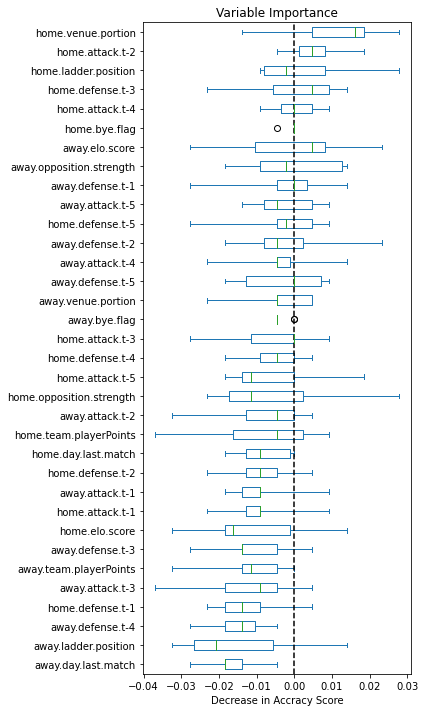

In [64]:
#Plot it
fig = importanceDF.plot.box(vert=False, whis=10)
fig.set_title('Variable Importance')
fig.axvline(x=0, color='k', linestyle='--')
fig.set_xlabel('Decrease in Accracy Score')
fig.figure.set_figheight(10) 
fig.figure.tight_layout()

### Variable Importance

## Model: Find the winner

In [ ]:
#import packages for modelling
from sklearn.ensemble import RandomForestClassifier

In [ ]:
model = RandomForestClassifier()
model.fit(trainX, trainWinner)

In [ ]:
trainYMitPred = (trainY
                     .with_columns(pl.Series(model.predict(trainX)).alias('Prediction'))
                     .with_columns(pl.when(pl.col('winner') == pl.col('Prediction')).then(pl.lit(1)).otherwise(pl.lit(0)).alias('Check'))
                )

In [ ]:
trainYMitPred.select(pl.col('Check')).sum()

In [ ]:
model.predict(testX)

In [ ]:
testYMitPred = (testY
                     .with_columns(pl.Series(model.predict(testX)).alias('Prediction'))
                     .with_columns(pl.when(pl.col('winner') == pl.col('Prediction')).then(pl.lit(1)).otherwise(pl.lit(0)).alias('Check'))
                )

In [ ]:
testYMitPred.select(pl.col('Check')).sum().item()

In [ ]:
testYMitPred.head(5)

In [ ]:
model.predict_proba(testX)

In [ ]:
142/216

In [75]:
#Run some tests on pararmeters
n_estimators=[50,75,100,125,130, 140, 150]
max_depth=[None, 10, 13, 14, 15, 16, 17]
min_samples_split=[2,3, 4, 5,8]
max_features=['sqrt', 'log2', None]

In [ ]:
#Test all combos and record the results
ne_list = []
mss_list = []
md_list = []
mf_list = []

for ne in n_estimators:
    for mss in min_samples_split:
            for mf in max_features:
                for md in max_depth:
                            #Create model
                            model = RandomForestClassifier(n_estimators=ne, max_depth=md, min_samples_split=mss, max_features=mf, random_state=20)
                            #Fit model
                            model.fit(trainX, trainWinner)
                            #Test checking
                            model.predict(testX)
                            testYMitPred = (testY
                                             .with_columns(pl.Series(model.predict(testX)).alias('Prediction'))
                                             .with_columns(pl.when(pl.col('winner') == pl.col('Prediction')).then(pl.lit(1)).otherwise(pl.lit(0)).alias('Check'))
                                            )
                            #get result
                            result.append(testYMitPred.select(pl.col('Check')).sum().item()/216)
                            #append parameters
                            ne_list.append(ne)
                            md_list.append(md)
                            mss_list.append(mss)
                            mf_list.append(mf)
                    
                    
#Display in df
paramTesting = pl.DataFrame({'n_estimators' : ne_list, 'max_depth' : md_list, 'Min_sample_split' : mss_list, 'Max_features' : mf_list, 
                             'Results': result})

In [ ]:
paramTesting.sort('Results', descending=True)

In [72]:
model = RandomForestClassifier(n_estimators=125, min_samples_split=3, random_state=20)
model.fit(trainX, trainWinner)

RandomForestClassifier(min_samples_split=3, n_estimators=125, random_state=20)

In [73]:
#save the model
import pickle
pickle.dump(model, open('aflModel.sav', 'wb'))

In [486]:
#save everythingelse
indexTeams.write_excel('indexTeams.xlsx')
distanceTravelled.write_excel('distanceTravelled.xlsx')
with open("eloScores", "wb") as fp:
    pickle.dump(eloScores[-1], fp)
(matchDate
     .with_columns(pl.col('team.round.id').max().over('Team').alias('MaxRound'))
     .filter(pl.col('team.round.id') == pl.col('MaxRound'))
     .select('Date', 'Team')
     .with_columns(pl.col('Team').replace(old=['Adelaide', 'GWS', 'Geelong', 'Gold Coast', 'West Coast', 'Footscray', 'Sydney'],
                                              new=['Adelaide Crows', 'GWS Giants', 'Geelong Cats', 'Gold Coast Suns', 'West Coast Eagles', 'Western Bulldogs', 'Sydney Swans']))).write_excel('matchDay.xlsx')  
allMatchesBothSides.filter(pl.col('compSeason.year') == 2023).write_excel('matchesBothSides.xlsx')